In [94]:
# Sam's Fans Fundraising Data Analysis Notebook

# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
# Set styles
sns.set(style="whitegrid")

In [84]:
# 2. Load Data
# Updated to load CSV file
# Ensure Donation_Data.csv is in the same directory

data = pd.read_csv('Donar_Data.csv', dtype={'Date': str})

data.head()

,Account Number,Date,Revenue Amount,Type,Fund,Campaign,Appeal,Primary City,Primary State,Primary ZIP Code
0,8231,2/18/25,$20.76,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43214-4014
1,2139,2/17/25,$78.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Galena,OH,43021
2,1566,2/15/25,$52.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Darien,CT,06820-3204
3,10382,2/15/25,$21.11,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Columbus,OH,43214
4,9739,2/15/25,$24.23,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,BTJ Website,Dublin,OH,43017


In [86]:
# 3. Quick Data Check
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9488 entries, 0 to 9487
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Account Number    9488 non-null   int64 
 1   Date              9488 non-null   object
 2   Revenue Amount    9304 non-null   object
 3   Type              9488 non-null   object
 4   Fund              9488 non-null   object
 5   Campaign          6111 non-null   object
 6   Appeal            3418 non-null   object
 7   Primary City      8993 non-null   object
 8   Primary State     8974 non-null   object
 9   Primary ZIP Code  8987 non-null   object
dtypes: int64(1), object(9)
memory usage: 741.4+ KB


,Account Number
count,9488.000000
mean,4062.043107
std,4038.607020
min,4.000000
25%,723.000000
50%,1841.500000
75%,8830.250000
max,10827.000000


In [88]:
# 4. Clean and Prepare Data
# Assume columns like: 'Donor ID', 'Amount', 'Date', 'Campaign', 'Recurring Payment?'


# 2. Parse Date column correctly (flexible format)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# 3. Check first 10 dates
print(data['Date'].head(10))

# 4. Now create YearMonth
data['YearMonth'] = data['Date'].dt.to_period('M')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month


0   2025-02-18
1   2025-02-17
2   2025-02-15
3   2025-02-15
4   2025-02-15
5   2025-02-15
6   2025-02-15
7   2025-02-14
8   2025-02-13
9   2025-02-12
Name: Date, dtype: datetime64[ns]


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/1118169147.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


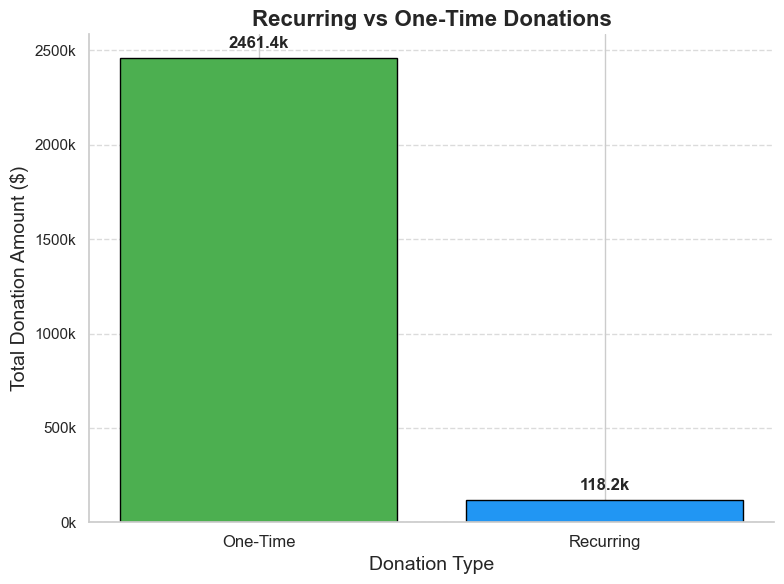

In [90]:
# 1. Clean Revenue Amount properly
data['Revenue Amount'] = data['Revenue Amount'].replace(r'[\$,]', '', regex=True).astype(float)

# 2. Simplify donation types
def categorize_type(x):
    if 'Recurring' in str(x):
        return 'Recurring'
    else:
        return 'One-Time'

data['Donation Type'] = data['Type'].apply(categorize_type)

# 3. Group
recurring_summary = data.groupby('Donation Type')['Revenue Amount'].sum()

# 4. Plot (visually enhanced)
fig, ax = plt.subplots(figsize=(8,6))

bars = ax.bar(recurring_summary.index, 
               recurring_summary.values, 
               color=['#4CAF50', '#2196F3'],  # Green and Blue
               edgecolor='black')

# Title and labels
ax.set_title('Recurring vs One-Time Donations', fontsize=16, fontweight='bold')
ax.set_xlabel('Donation Type', fontsize=14)
ax.set_ylabel('Total Donation Amount ($)', fontsize=14)

# Y-axis in thousands (e3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height/1000:.1f}k', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Make x-axis labels horizontal
plt.xticks(rotation=0, fontsize=12)

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


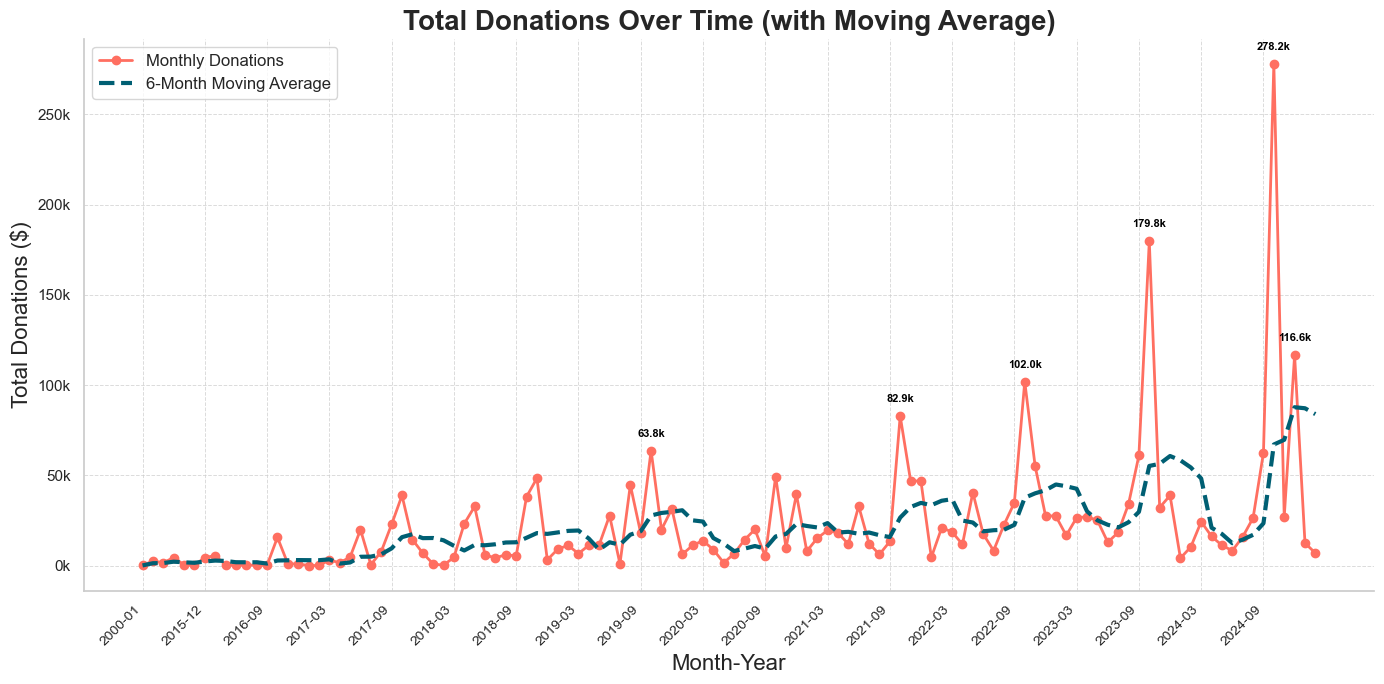

In [96]:
# 1. Group monthly donations
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()

# 2. Calculate Moving Average (6-month rolling)
monthly_donations['6_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=6, min_periods=1).mean()

# 3. Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Main donations line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['Revenue Amount'], 
        marker='o', 
        linestyle='-', 
        color='#FF6F61', 
        linewidth=2, 
        label='Monthly Donations')

# Moving Average line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['6_Month_MA'], 
        color='#005f73', 
        linewidth=3, 
        linestyle='--', 
        label='6-Month Moving Average')

# Title and labels
ax.set_title('Total Donations Over Time (with Moving Average)', fontsize=20, fontweight='bold')
ax.set_xlabel('Month-Year', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

# Format Y-axis in Thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Fix X-axis: show label every 6 months
step = 6
plt.xticks(ticks=range(0, len(monthly_donations), step), 
           labels=monthly_donations['YearMonth'].astype(str)[::step], 
           rotation=45, ha='right', fontsize=10)

# Grid
ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# OPTIONAL: Annotate only very high spikes
threshold = monthly_donations['Revenue Amount'].quantile(0.95)
for i, row in monthly_donations.iterrows():
    if row['Revenue Amount'] >= threshold:
        ax.annotate(f'{row['Revenue Amount']/1000:.1f}k', 
                    (i, row['Revenue Amount']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=8, fontweight='bold', color='black')

# Add legend
ax.legend(fontsize=12)

# Layout
plt.tight_layout()

# Show plot
plt.show()


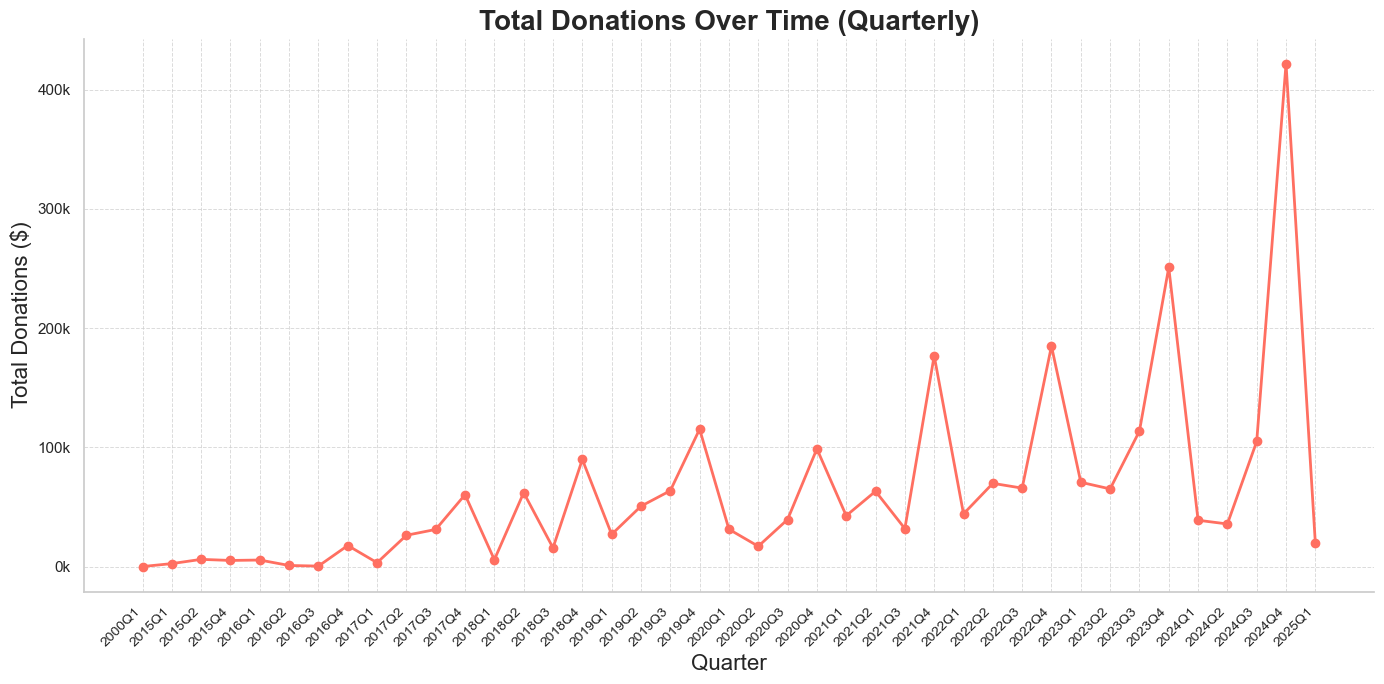

In [98]:
# 1. Group donations quarterly
data['Quarter'] = data['Date'].dt.to_period('Q')
quarterly_donations = data.groupby('Quarter')['Revenue Amount'].sum().reset_index()

# 2. Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(quarterly_donations['Quarter'].astype(str), 
        quarterly_donations['Revenue Amount'], 
        marker='o', 
        linestyle='-', 
        color='#FF6F61', 
        linewidth=2)

ax.set_title('Total Donations Over Time (Quarterly)', fontsize=20, fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))
plt.xticks(rotation=45, ha='right', fontsize=10)

ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


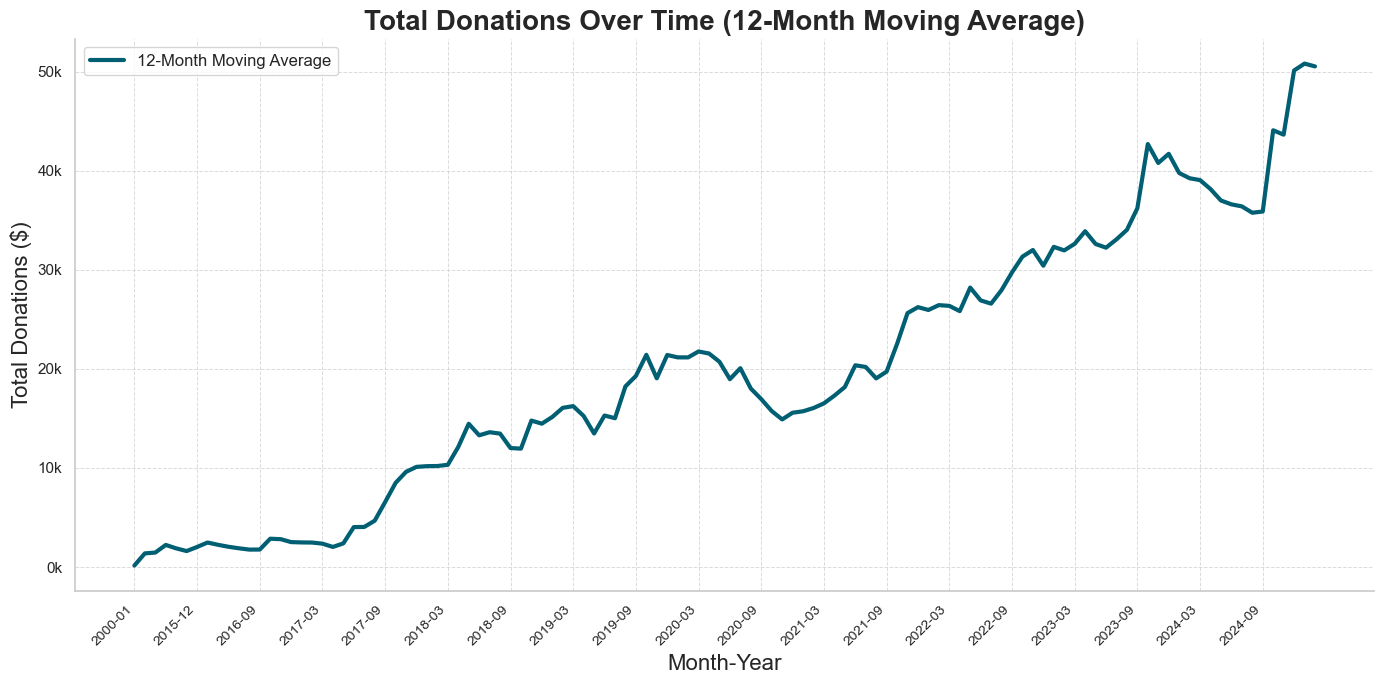

In [106]:
# 1. 12-Month Moving Average
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()
monthly_donations['12_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=12, min_periods=1).mean()

# 2. Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#005f73', 
        linewidth=3, 
        linestyle='-', 
        label='12-Month Moving Average')

ax.set_title('Total Donations Over Time (12-Month Moving Average)', fontsize=20, fontweight='bold')
ax.set_xlabel('Month-Year', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))
plt.xticks(ticks=range(0, len(monthly_donations), 6), 
           labels=monthly_donations['YearMonth'].astype(str)[::6], 
           rotation=45, ha='right', fontsize=10)

ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

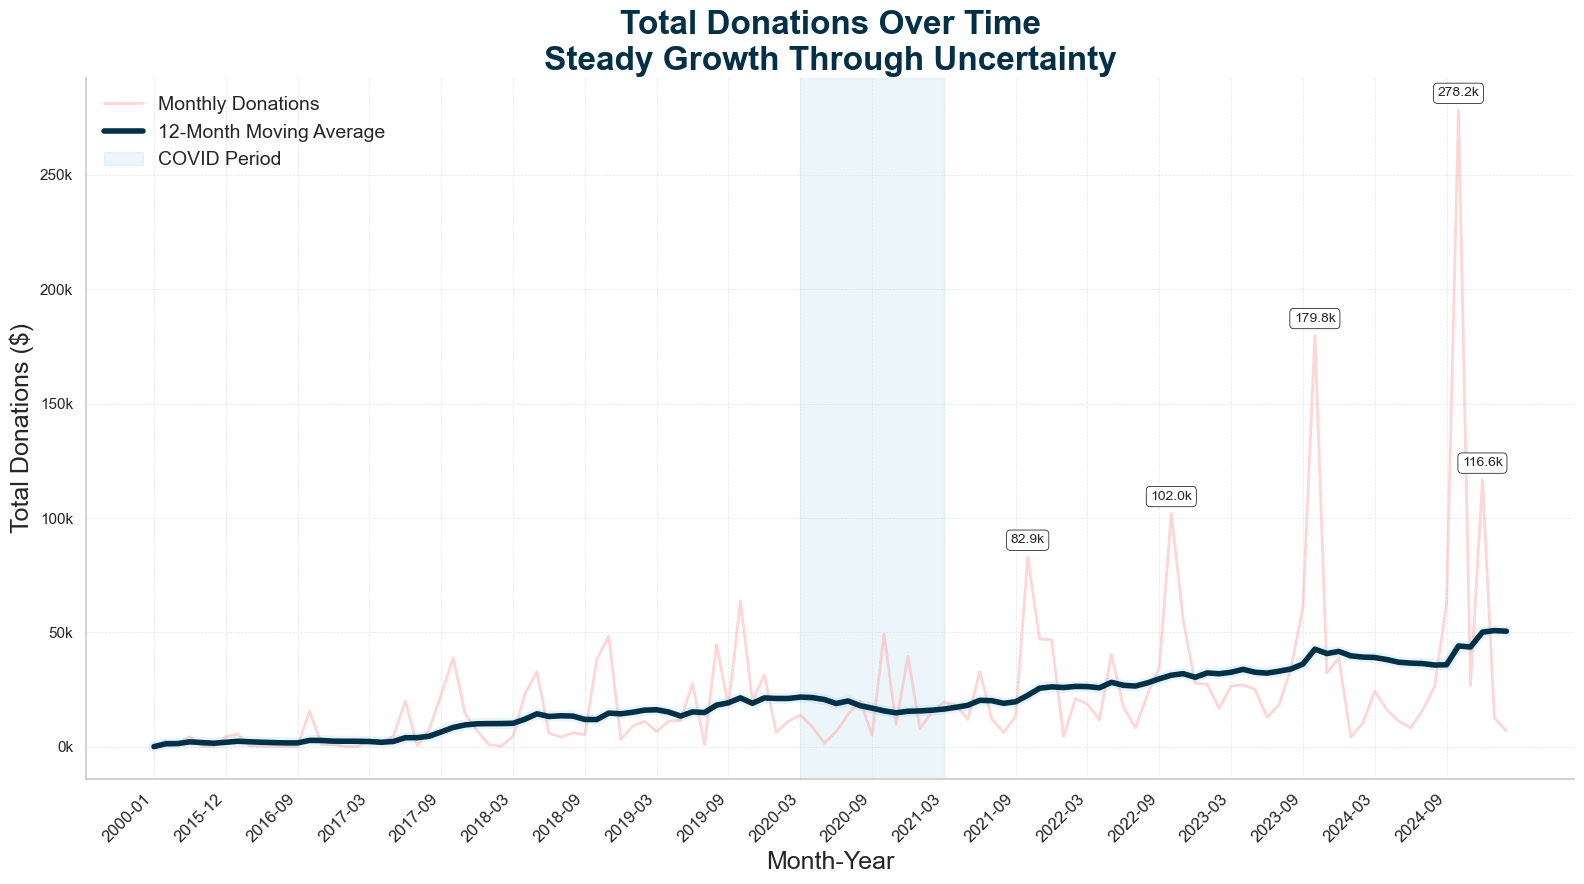

In [108]:
# 1. Group and Calculate Moving Average
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()
monthly_donations['12_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=12, min_periods=1).mean()

# 2. Plot
fig, ax = plt.subplots(figsize=(16, 9))

# Faded Monthly Donations (new soft color)
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['Revenue Amount'], 
        color='#FFADAD',   # Soft Coral Pink
        alpha=0.5, 
        linewidth=2, 
        linestyle='-', 
        label='Monthly Donations')

# Strong Moving Average Line (dark bold color)
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#023047',   # Dark Blue
        linewidth=4, 
        linestyle='-', 
        label='12-Month Moving Average', 
        zorder=3)

# Shadow/Glow effect under Moving Average
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#8ecae6',  # Light Glow Blue
        linewidth=8, 
        alpha=0.2, 
        zorder=2)

# Title and Subtitle
ax.set_title('Total Donations Over Time\nSteady Growth Through Uncertainty', fontsize=24, fontweight='bold', color='#023047', loc='center')
ax.set_xlabel('Month-Year', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)

# Y-axis formatter
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# X-axis formatting
plt.xticks(ticks=range(0, len(monthly_donations), 6), 
           labels=monthly_donations['YearMonth'].astype(str)[::6], 
           rotation=45, ha='right', fontsize=12)

# Highlight COVID Period (more beautiful light blue)
ax.axvspan('2020-03', '2021-03', color='#d0e8f2', alpha=0.4, label='COVID Period')

# Annotate Key Donation Peaks
top_peaks = monthly_donations.nlargest(5, 'Revenue Amount')
for i, row in top_peaks.iterrows():
    ax.annotate(f'{row["Revenue Amount"]/1000:.1f}k', 
                (i, row['Revenue Amount']), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

# Light Grid
ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)

# Remove Top/Right Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(fontsize=14, loc='upper left', frameon=False)

# Layout
plt.tight_layout()

# Show
plt.show()


In [ ]:
# --- 5.3 Campaign vs Unprompted Donations ---
data['Campaign_Status'] = data['Campaign'].apply(lambda x: 'Campaign' if pd.notnull(x) and x != '' else 'Unprompted')

campaign_summary = data.groupby('Campaign_Status')['Amount'].sum()

# Plot
campaign_summary.plot(kind='bar', title='Campaign vs Unprompted Donations', xlabel='Type', ylabel='Total Donations', figsize=(8,5), color='coral')
plt.show()


In [ ]:
# --- 5.4 Donation Size Distribution ---
# Plot histogram of donation sizes
plt.figure(figsize=(10,6))
plt.hist(data['Amount'], bins=30, color='purple', edgecolor='black')
plt.title('Donation Size Distribution')
plt.xlabel('Donation Amount ($)')
plt.ylabel('Number of Donations')
plt.xlim(0, 5000) # Adjust based on data range
plt.show()

In [ ]:
# --- 5.5 Large Donations vs Small Donations ---
large_donations = data[data['Amount'] > 1000]['Amount'].sum()
small_donations = data[data['Amount'] <= 1000]['Amount'].sum()

# Bar plot
plt.bar(['> $1000', '<= $1000'], [large_donations, small_donations], color=['gold', 'silver'])
plt.title('Proceeds: Large vs Small Donations')
plt.xlabel('Donation Size')
plt.ylabel('Total Proceeds')
plt.show()

In [ ]:
# --- 5.6 Top Donors (High-Value Donors) ---
top_donors = data.groupby('Donor ID')['Amount'].sum().sort_values(ascending=False).head(10)

# Plot
top_donors.plot(kind='barh', title='Top 10 Donors by Total Donation Amount', figsize=(8,6), color='teal')
plt.xlabel('Total Donation Amount')
plt.ylabel('Donor ID')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 6. Summary Findings
print("\nSUMMARY FINDINGS:")
print("Recurring vs One-Time Donations:\n", recurring_summary)
print("\nCampaign vs Unprompted Donations:\n", campaign_summary)
print("\nLarge Donations Total: $", round(large_donations, 2))
print("Small Donations Total: $", round(small_donations, 2))
print("\nTop 10 Donors:\n", top_donors)

In [ ]:
# 7. (Optional) Save Processed Data
# data.to_csv('processed_donation_data.csv', index=False)